#**XG Boost** 
*(use on google collab for better inference times)* 

In [ ]:
# no need to run this cell on google colab, packages come pre-installed
%pip install -r ../requirements.txt

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb

#**LOAD MNIST**

In [30]:
mnist = loadmat('../data/MNIST.mat')

# Extract data
X_train_full = mnist['train_fea']
y_train_full = mnist['train_gnd'].ravel()
X_test = mnist['test_fea']
y_test = mnist['test_gnd'].ravel()

# Split training into train and validation (55k train, 5k val)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

# shift labels to 0-9
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (55000, 784), (55000,)
Validation set: (5000, 784), (5000,)
Test set: (10000, 784), (10000,)


#**MODEL FITTING AND EARLY STOPPING**
- may take a minute to run

In [ ]:
# Early stopping callback to prevent overfitting
early_stop = xgb.callback.EarlyStopping(
    rounds=10, 
    metric_name='mlogloss', 
    data_name='validation_0', 
    save_best=True,
    min_delta=1e-2
)
# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(
    tree_method="hist",
    n_estimators=2000,
    eval_metric="mlogloss",
    device = 'cuda',
    callbacks=[early_stop]
)

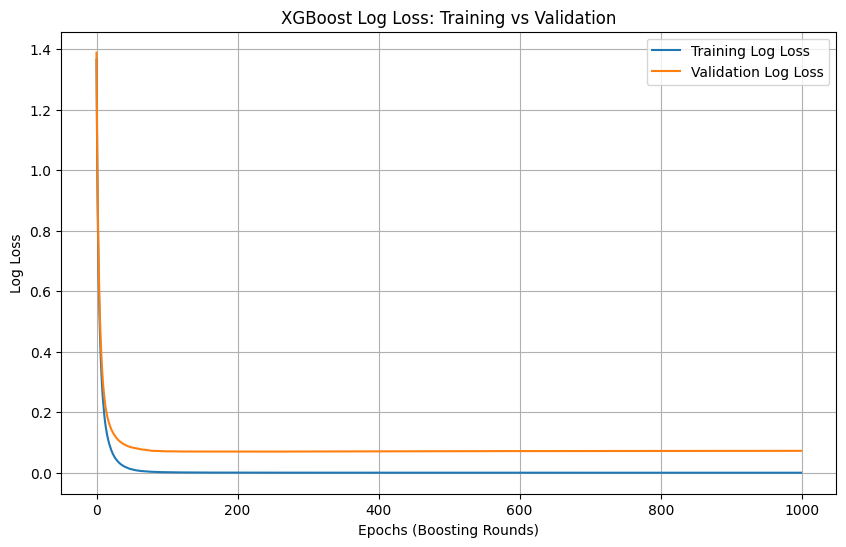

In [ ]:
# Fitting model using train and validation sets
clf.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=False  # Set to True if you want to see the log stream
)

results = clf.evals_result()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Training Log Loss')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation Log Loss')
plt.legend()
plt.xlabel('Epochs (Boosting Rounds)')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss: Training vs Validation')
plt.grid(True)
plt.show()

#**Performance Analysis**

In [44]:
print(f"Best model found at iteration: {clf.best_iteration}")

# This automatically uses the best iteration
y_test_pred = clf.predict(X_test)

# Calculate test accuracy
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (using best model): {test_acc:.4f}")

Best model found at iteration: 999
Test Accuracy (using best model): 0.9807


#**Generate confusion matrix**

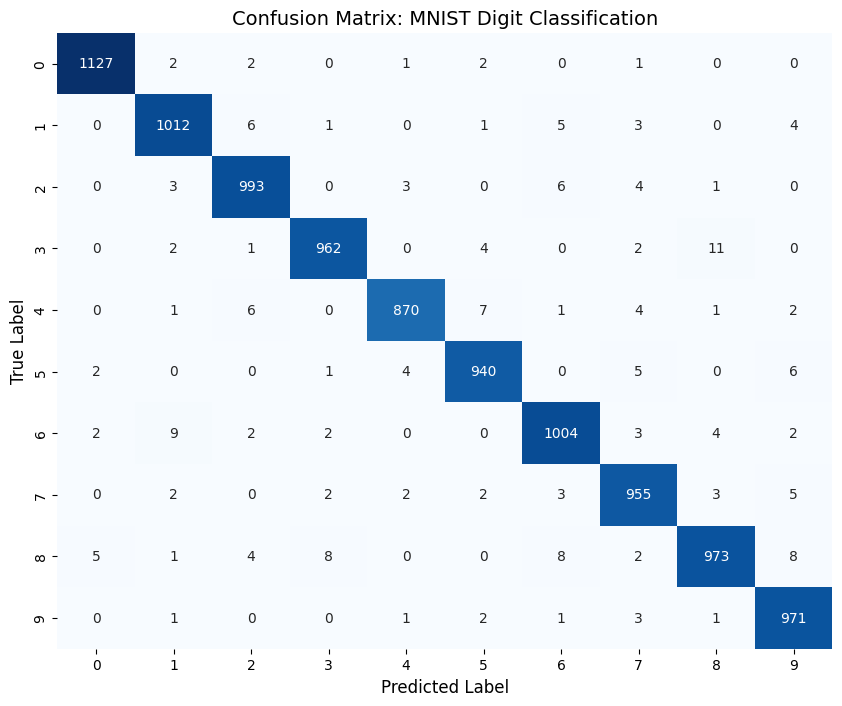


Classification Report:

              precision    recall  f1-score   support

           0     0.9921    0.9930    0.9925      1135
           1     0.9797    0.9806    0.9801      1032
           2     0.9793    0.9832    0.9812      1010
           3     0.9857    0.9796    0.9826       982
           4     0.9875    0.9753    0.9814       892
           5     0.9812    0.9812    0.9812       958
           6     0.9767    0.9767    0.9767      1028
           7     0.9725    0.9805    0.9765       974
           8     0.9789    0.9643    0.9715      1009
           9     0.9729    0.9908    0.9818       980

    accuracy                         0.9807     10000
   macro avg     0.9806    0.9805    0.9806     10000
weighted avg     0.9807    0.9807    0.9807     10000



In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
            cm,
            cmap="magma",
            annot=True,
            fmt="d",
            cbar=True,
        )
plt.title('Confusion Matrix: MNIST Digit Classification', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred, digits=4))